## Imports

In [229]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import random
import sys
import math

from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

import time
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

import genetic as gen
import helpers as hp
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Firebase

In [230]:
cred = credentials.Certificate('private-key.json')
firebase_admin.initialize_app(cred)
db = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [231]:
# Set up Firebase test document
db = firestore.client()

collection = db.collection("cortex")
doc = collection.document("cortex")

## Helpers 

In [232]:
def shuffle_dataset(x,y):
    c = list(zip(x, y))
    random.shuffle(c)
    x, y = zip(*c)
    return(x,y)

## Global variables 

In [233]:
global_number_of_feature_selection_methods = 2

# Import data and events

In [234]:
url = "https://raw.githubusercontent.com/janlucasandmann/Brainbridge/main/data/1643297048.3875499.csv"
data_raw = pd.read_csv(url).values.tolist()
y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

## Clean up data

In [235]:
def deleteNaN(x, num_of_dimensions):
    res = []
    
    if num_of_dimensions == 1:
        for val in x:
            if math.isnan(val):
                    res.append(0)
            else:
                res.append(val)
            
    elif num_of_dimensions == 2:
        for row in x:
            row_new = []
            for val in row:
                if math.isnan(val):
                    row_new.append(0)
                else:
                    row_new.append(val)
            res.append(row_new)
    
    return res        

## Check validity of data

In [236]:
def checkMatchingOfDatasetLength(x,y):
    if len(x) == len(y):
        return(True, len(x), len(y))
    else:
        return(False)

# Analyze complexity of data

In [237]:
def getSize(x,y):
    xSize = sys.getsizeof(x)
    ySize = sys.getsizeof(y)
    return xSize + ySize

def splitData(x, y, packageSize):
    x_res = []
    y_res = []
    c = 0 # counter
    xc = 0 # counter for datarows in x
    
    print(len(y))
    
    y_res_row = []
    x_res_row = []
    
    for i in y:
        if c < packageSize:
            y_res_row.append(i)
            x_res_row.append(x[xc])
            
            c += 1
        else:
            y_res.append(y_res_row)
            y_res_row = []
            x_res.append(x_res_row)
            x_res_row = []
            
            x_res_row.append(x[xc])
            y_res_row.append(i)
            
            c = 0
            
        xc += 1
        
    x_res.append(x_res_row)
    y_res.append(y_res_row)
        
    return(x_res, y_res)

def decideDataSplitByLoadingTime(time, x, y, shuffle):
    if shuffle:
        x,y = shuffle_dataset(x,y)
        
        # Estimate loading time for different feature generation / selection
        # algorithms and training of AI models
        
    return(splitData(x, y, 200))

In [238]:
def independenceTest(x, y, subset_size, iterations):
    
    i = 0
    x_res = []
    y_res = []
    corrs = []
    
    while i < iterations:
        x_new, y_new = shuffle_dataset(x,y)
        
        x_new_res = x_new[:subset_size]
        y_new_res = y_new[:subset_size]
        
        corr_raw = 0
        val_counter = 0
        
        for row in np.corrcoef(x_new_res, x):
            for val in row:
                corr_raw += math.sqrt(val ** 2)
                val_counter += 1
            
        corr = corr_raw / val_counter
        x_res.append(x_new_res)
        y_res.append(y_new_res)
        corrs.append(corr)
        
        i += 1
        
    idx_order = np.argsort(np.array(corrs))[::-1]
    
    corrs_sorted = np.array(corrs)[idx_order]
    x_res_sorted = np.array(x_res)[idx_order]
    y_res_sorted = np.array(y_res)[idx_order]
    
    return(x_res_sorted[0], y_res_sorted[0], corrs_sorted[0])

In [239]:
def execute_independenceTest(x,y,dataset_reduction_size):
    print("Split dataset: independence test")
    start = time.time()
    c = 0
    while c < 0.83:
        x,y,c = independenceTest(x, y, dataset_reduction_size, 100)
    print("Correlation between datasets: ", c)
    end = time.time()
    independence_test_time = end - start
    
    return(x,y,independence_test_time)

# Artifact Removal 

In [240]:
def artifactRemoval(x,y):
    return x,y

# Feature Generation

### Generation of features, that describe intervals as a whole

In [241]:
def getMeans(x):
    res = []
    
    for row in x:
        res.append(np.mean(row))
        
    return res

# Create validation set

In [335]:
def createValidationSet(x, y, split_number):
    x_res, y_res, x_val, y_val = [], [], [], []
    
    i = 0
    for row in x:
        if i < len(x) - split_number:
            x_res.append(row)
            y_res.append(y[i])
        else:
            x_val.append(x[i])
            y_val.append(y[i])
        i += 1
        
    print(len(x_res), len(y_res), len(x_val), len(y_val), " Was ist in createValidationSet los?")
    
    return(x_res, y_res, x_val, y_val)

# Feature Selection

In [243]:
def ridgeFeatureSelection(x,y, num_of_features): 
    indices = []
    c = 0
    for val in x[0]:
        indices.append(c)
        c += 1
    
    ridge = RidgeCV(alphas=np.logspace(-10, 10, num=1)).fit(x,y)
    importance = np.array(np.abs(ridge.coef_))
    
    res = []
    
    idx_order = np.argsort(importance)[::-1]
    indices = np.array(indices)[idx_order]
    
    for row in x:
        row_sorted = np.array(row)[idx_order]
        res.append(row_sorted[:num_of_features])
        
    return(res, indices[:num_of_features])

In [244]:
def skbFeatureSelection(x,y,num_of_features):
    print("Start fitting SKB model")
    selector = SelectKBest(score_func=f_classif, k=num_of_features)
    selector.fit(x, y)
    indices = selector.get_support()
    print("Finished fitting SKB model")
    
    res = []
    selected_indices = []
    
    for row in x:
        c = 0
        row_res = []
        for val in row:
            if indices[c] == True:
                row_res.append(val)
            c += 1
        res.append(row_res)
        
    c = 0
    
    for val in indices:
        if val == True:
            selected_indices.append(c)
        c += 1
              
    return(res, selected_indices)

In [245]:
def sfsForwardFeatureSelection(x,y, num_of_features):  
    
    ridge = RidgeCV(alphas=np.logspace(-10, 10, num=1)).fit(x,y)
    
    sfs_forward = SequentialFeatureSelector(
        ridge, n_features_to_select=num_of_features, direction="forward"
    ).fit(x, y)
    
    indices = sfs_forward.get_support()
    res = []
    selected_indices = []
    
    for row in x:
        c = 0
        row_res = []
        for val in row:
            if indices[c] == 1:
                row_res.append(val)
            c += 1
        res.append(row_res)
        
    c = 0
    
    for val in indices:
        if val == 1:
            selected_indices.append(c)
        c += 1
              
    return(res, selected_indices)

In [246]:
def sfsBackwardFeatureSelection(x,y, num_of_features):    
    
    ridge = RidgeCV(alphas=np.logspace(-10, 10, num=1)).fit(x,y)
    
    sfs_backward = SequentialFeatureSelector(
        ridge, n_features_to_select=num_of_features, direction="backward"
    ).fit(x, y)
    
    indices = sfs_backward.get_support()
    res = []
    selected_indices = []
    
    for row in x:
        c = 0
        row_res = []
        for val in row:
            if indices[c] == 1:
                row_res.append(val)
            c += 1
        res.append(row_res)
        
    c = 0
    
    for val in indices:
        if val == 1:
            selected_indices.append(c)
        c += 1
    
              
    return(res, selected_indices)

In [247]:
def featureSelectionValidation(x, indices):
    res = []
    
    for row in x:
        res_row = []
        c = 0
        for val in row:
            if c in indices:
                res_row.append(val)
            c += 1
        res.append(res_row)
        
    return res

In [311]:
def execute_featureSelection(x,y,x_val,number_of_features):
    sfsForwardFeatureSelection_time = 0
    # Feature selection
    print("Feature selection: skbFeatureSelection")
    start = time.time()
    features_a, indices_a = skbFeatureSelection(x,y, number_of_features)
    end = time.time()
    ridgeFeatureSelection_time = end - start
    print("Feature selection: sfsForwardFeatureSelection")
    #start = time.time()
    #features_b, indices_b = sfsForwardFeatureSelection(x,y, number_of_features)
    #end = time.time()
    #sfsForwardFeatureSelection_time = end - start
    print("Feature selection: Genetic algorithm")
    start = time.time()
    indices_c = gen.simulateEvolution(transposeForGeneticAlgorithm(x), number_of_features, 96, 5, 20, 0.5, (len(y) - 40), 250, y)
    features_c = featureSelectionValidation(x, indices_c)
    end = time.time()
    geneticAlgorithmFeatureSelection_time = end - start
    features = [features_a, features_c]
    #features = [features_a, features_b, features_c]
    indices_combined = [indices_a, indices_c]
    #indices_combined = [indices_a, indices_b, indices_c]

    # Feature selection for validation set
    features_val_a = featureSelectionValidation(x_val, indices_a)
    #features_val_b = featureSelectionValidation(x_val, indices_b)
    features_val_c = featureSelectionValidation(x_val, indices_c)

    #features_val = [features_val_a, features_val_b, features_val_c]
    features_val = [features_val_a, features_val_c]
    
    return(features, features_val, indices_combined, ridgeFeatureSelection_time, sfsForwardFeatureSelection_time, geneticAlgorithmFeatureSelection_time)

In [317]:
def execute_featureSelection_nof(x,y,x_val, number_of_features):
    sfsForwardFeatureSelection_time = 0
    features, indices = skbFeatureSelection(x,y, number_of_features)
    # Feature selection for validation set
    features_val = featureSelectionValidation(x_val, indices)
    
    return features, features_val

# Model Selection

In [249]:
def linearModel(x,y):
    reg = linear_model.Ridge(alpha=.5)
    reg.fit(x,y)
    return reg

In [250]:
def linearModelLasso(x,y):
    reg = linear_model.Lasso(alpha=0.001)
    reg.fit(x,y)
    return reg

In [251]:
def linearModelLassoLars(x,y):
    reg = linear_model.LassoLars(alpha=0.001, normalize=True)
    reg.fit(x,y)
    return reg

In [252]:
def supportVectorMachine(x,y):
    clf = svm.SVC()
    clf.fit(x,y)
    return clf

In [253]:
def stochasticGradient(x,y):
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=40)
    clf.fit(x,y)
    return clf

In [254]:
def randomForest(x,y,depth=10):
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(x, y)
    return clf

In [255]:
def adaBoost(x,y,estimators=100):
    clf = AdaBoostClassifier(n_estimators=estimators, random_state=0)
    clf.fit(x, y)
    return clf

In [256]:
def knn(x,y,neighbors=10):
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(x, y)
    return neigh

In [257]:
def gaussianNB(x,y,):
    clf = GaussianNB()
    clf.fit(x,y)
    return clf

# Model evaluation

In [265]:
def trainModels(x,y):
    a = gaussianNB(x,y)
    b = knn(x,y)
    c = adaBoost(x,y)
    d = stochasticGradient(x,y)
    e = randomForest(x,y)
    
    return([a,b,c,d,e])

In [266]:
def makePredictions(models, x):
    res = []
    
    for model in models:
        res.append(model.predict(x))
        
    return res

In [295]:
def evaluateModels(predictions, y):
    corrs = []
    losses = []
    accuracies = []
    
    print(len(y_val), len(y))
    
    for pred in predictions:
        print("loss", log_loss([pred], [y]))
        print("accuracy", accuracy_score(pred, y))
        
        try:
            corrs.append(np.corrcoef(pred,y)[0][1])
        except:
            corrs.append(0)
        try:
            losses.append(log_loss(pred, y))
        except:
            losses.append(0)
        try:
            accuracies.append(accuracy_score(pred, y))
        except:
            accuracies.append(0)
        
        
    return corrs, accuracies, losses

In [296]:
def execute_modelTraining(features,y, features_val, y_val, indices_combined):
    models = []
    models_flat = []
    pred_res = []
    indices_res = []

    c = 0
    print("Train models")
    start = time.time()
    for feature in features:
        m_temp = trainModels(feature,y)
        models.append(m_temp)

        for row in m_temp:
            indices_res.append(indices_combined[c])

        c += 1
    end = time.time()
    train_time = end - start
    print("Make predictions")
    i = 0
    for model_section in models:
        pred_res.append(makePredictions(model_section, features_val[i]))
        for model in model_section:
            models_flat.append(model)
        i += 1


    pred = []
    for pred_section in pred_res:
        for pr in pred_section:
            pred.append(pr)

    evaluation, accuracy, loss = evaluateModels(pred, y_val)
    evaluation = deleteNaN(evaluation, 1)
    accuracy = deleteNaN(accuracy, 1)
    loss = deleteNaN(loss, 1)
    
    return models_flat, evaluation, accuracy, loss, train_time, indices_res

In [319]:
def execute_modelEvaluation_nof(x, y, x_val, y_val):
    model = adaBoost(x,y,estimators=100)
    pred = model.predict(x_val)
    
    return np.corrcoef(pred, y_val)[0][1]

In [297]:
def chooseModelBasedOnTraining(models, evaluations, x, y):
    
    global global_number_of_feature_selection_methods
    modulo = len(models) / global_number_of_feature_selection_methods
        
    c = 0
    
    while c < len(models):
        if c == np.argmax(evaluations) and c % modulo == 0:
            return gaussianNB(x,y)
        elif c == np.argmax(evaluations) and c % modulo == 1:
            return knn(x,y)
        elif c == np.argmax(evaluations) and c % modulo == 2:
            return adaBoost(x,y)
        elif c == np.argmax(evaluations) and c % modulo == 3:
            return stochasticGradient(x,y)
        elif c == np.argmax(evaluations) and c % modulo == 4:
            return randomForest(x,y)
        
        c += 1

In [298]:
def chooseModelBasedOnTrainingTest(right_index):
    
    global global_number_of_feature_selection_methods
    
    modulo = 6
        
    c = 0
    fs_count = 0
    i_count = 0
    
    while c < 12:
        if c == right_index and c % modulo == 0:
            return 0
        elif c == right_index and c % modulo == 1:
            return 1
        elif c == right_index and c % modulo == 2:
            return 2
        elif c == right_index and c % modulo == 3:
            return 3
        elif c == right_index and c % modulo == 4:
            return 4
        elif c == right_index and c % modulo == 5:
            return 5
        
        c += 1

In [299]:
i = 0
while i < 12:
    print(chooseModelBasedOnTrainingTest(i))
    i += 1

0
1
2
3
4
5
0
1
2
3
4
5


In [272]:
def transposeForGeneticAlgorithm(x):
    # Manually transpose array, because np.tranpose does not work here (why ever)...
    c = 0
    X_reduced_res_transposed = []
    len_row_zero = 0
    events_ref = []

    while c < len(x[0]):
        X_reduced_res_transposed_row = []
        for row in x:
            i = 0
            for val in row:
                if i == c:
                    X_reduced_res_transposed_row.append(val)
                i += 1

        if c == 0: # in some cases the row contains too few values. If so, this must be detected to prevent training from crashing.
            len_row_zero = len(X_reduced_res_transposed_row)

        if len(X_reduced_res_transposed_row) == len_row_zero:
            X_reduced_res_transposed.append(X_reduced_res_transposed_row)
            #events_ref.append(events[c])

        c += 1
    
    return X_reduced_res_transposed

# Combined process

In [337]:
def training(x, y, reduce, dataset_reduction_size=100, independence_test_nor=100, training_valset_size=50, repititions=1, min_number_of_features=10, max_number_of_features = 50):
    
    x = deleteNaN(x, 2)
    if not checkMatchingOfDatasetLength(x,y):
        return False
    
    # Measure time
    independence_test_time = 0
    ridgeFeatureSelection_time = 0
    sfsForwardFeatureSelection_time = 0
    geneticAlgorithmFeatureSelection_time = 0
    train_time = 0
    
    # Combined list, that stores average evaluations
    evaluations_res = []
    evaluations_combined = []
    evaluations_res_raw = []
    # Store model accuracy
    accuracy_res = []
    accuracy_combined = []
    accuracy_res_raw = []
    # Store model loss
    loss_res = []
    loss_combined = []
    loss_res_raw = []
    
    # Artifact removal
    x_raw,y_raw = artifactRemoval(x,y)
    
    nor = len(x)
    noa = len(x[0])
    
    # Feature Generation
    x_raw,y_raw = x_raw,y_raw
    
    # Split dataset
    if reduce:
        x_raw,y_raw,independence_test_time_raw = execute_independenceTest(x_raw,y_raw,dataset_reduction_size)
        independence_test_time += independence_test_time_raw
        

        
        
    print("Start evaluation of number of features")
    start = time.time()
    fc = min_number_of_features
    evaluation_nof = []
    nof = []
    
    while fc <= max_number_of_features + 20:
        
        try:
        
            # Shuffle dataset
            x_raw,y_raw = shuffle_dataset(x_raw,y_raw)

            # Create validation set
            x, y, x_val, y_val = createValidationSet(x_raw, y_raw, training_valset_size)

            features, features_val = execute_featureSelection_nof(x,y,x_val, fc)

            # Evayluate adaBoost Model with given number of features
            evaluation_nof.append(execute_modelEvaluation_nof(features, y, features_val, y_val))

            nof.append(fc)

            fc += 5
            
        except:
            break
        
        
    number_of_features = nof[np.argmax(np.array(evaluation_nof))]
        
    # Save time for evaluation of number of features
    end = time.time()
    nof_evaluation_time = end - start
        
        
        
        
        
    
    ic = 0
    while ic < repititions + 3:
        try:
            # Shuffle dataset
            x,y = shuffle_dataset(x,y)

            """
            # Split dataset to parallelize training
            # Artifact removal
            # Feature Generation
            # Create validation set
            # Feature selection
            # Feature selection for validation set
            # model selection
            # model finetuning
            """

            # Create validation set
            x, y, x_val, y_val = createValidationSet(x_raw, y_raw, training_valset_size)

            # Feature selection
            features, features_val, indices_combined, ridgeFeatureSelection_time_raw, sfsForwardFeatureSelection_time_raw, geneticAlgorithmFeatureSelection_time_raw = execute_featureSelection(x,y,x_val,number_of_features)

            # Get feature selection time
            ridgeFeatureSelection_time += ridgeFeatureSelection_time_raw
            sfsForwardFeatureSelection_time += sfsForwardFeatureSelection_time_raw
            geneticAlgorithmFeatureSelection_time += geneticAlgorithmFeatureSelection_time_raw

            # Model training
            models_flat, evaluations, accuracy, loss, train_time_raw, indices_res = execute_modelTraining(features, y, features_val, y_val, indices_combined)
            # Get model training time
            train_time += train_time_raw



            # Fill evaluation metrics....
            if ic == 0:
                evaluations_res_raw = evaluations
                for i in evaluations:
                    evaluations_combined.append([i])

                accuracy_res_raw = accuracy
                for i in accuracy:
                    accuracy_combined.append([i])

                loss_res_raw = loss
                for i in loss:
                    loss_combined.append([i])
            else:
                a = 0
                for val in evaluations:
                    evaluations_res_raw[a] += val
                    evaluations_combined[a].append(val)
                    a += 1

                a = 0
                for val in accuracy:
                    accuracy_res_raw[a] += val
                    accuracy_combined[a].append(val)
                    a += 1

                a = 0
                for val in loss:
                    loss_res_raw[a] += val
                    loss_combined[a].append(val)
                    a += 1
                    
            ic += 1
        
        except:
            break
                
                
                
        
        
        
    for i in evaluations_res_raw:
        evaluations_res.append(i / (ic))
        
    for i in accuracy_res_raw:
        accuracy_res.append(i / (ic))
        
    for i in loss_res_raw:
        loss_res.append(i / (ic))
    
    predictions_res = evaluations_combined[np.argmax(evaluations_res)]
    accuracy_scores_topmodel = accuracy_combined[np.argmax(evaluations_res)]
    loss_scores_topmodel = loss_combined[np.argmax(loss_res)]
    
    # Generate model descriptions
    model_descriptions = ["skb GNB", "skb KNN", "skb Ada", "skb SGD", "skb RF",
                         #"sfs GNB", "sfs KNN", "sfs Ada", "sfs SGD", "sfs RF",
                         "gen GNB", "gen KNN", "gen Ada", "gen SGD", "gen RF"]
    model_description = model_descriptions[np.argmax(evaluations_res)]
        
    # Make Firebase entry
    doc.update({
        "number_of_rows": nor,
        "number_of_attributes": noa,
        "number_of_rows_after_independence_test": independence_test_nor,
        "independence_test_time": independence_test_time,
        "ridge_feature_selection_time": ridgeFeatureSelection_time,
        "sfs_forward_feature_selection_time": sfsForwardFeatureSelection_time,
        "genetic_algorithm_feature_selection_time": geneticAlgorithmFeatureSelection_time,
        "training_time": train_time,
        "number_of_rows_training_val_set": independence_test_nor - training_valset_size,
        "model_descriptions": model_descriptions,
        "evaluations": evaluations_res,
        "dataset_reduction": reduce,
        "dataset_reduction_size": dataset_reduction_size,
        "selected_model": model_description,
        "prediction_scores": predictions_res,
        "accuracy_scores": accuracy_res,
        "accuracy_scores_topmodel": accuracy_scores_topmodel,
        "loss_scores": loss_res,
        "loss_scores_topmodel": loss_scores_topmodel,
        "nof_evaluation_time": nof_evaluation_time,
        "number_of_features": number_of_features,
        "number_of_features_evaluation": evaluation_nof
    })
    
    
    return models_flat, evaluations_res, model_descriptions, indices_res

In [338]:
def cortex(x, y, reduce=True, validation_set_size = 50, number_of_pred_val_steps=50, repititions=1, min_number_of_features=10, max_number_of_features = 50):
    print("Entering training")
    models, evaluations, model_descriptions, indices_raw = training(x, y, reduce, repititions=repititions, min_number_of_features=min_number_of_features, training_valset_size = validation_set_size, max_number_of_features=max_number_of_features)
        
    # delete NaN vals in x
    x = deleteNaN(x, 2)
    x_raw, y_raw = x,y
    
    
    # shuffle data for training
    x_raw,y_raw = shuffle_dataset(x_raw, y_raw)

    # Get indices for feature selection
    indices = np.array(indices_raw)[np.argmax(evaluations)]
    # Feature selection based on train results
    features = featureSelectionValidation(x, indices)

    # Get top model from training session
    if reduce:
        model = chooseModelBasedOnTraining(models, evaluations, features, y)
    else:
        #model = models[np.argmax(evaluations)]
        model = chooseModelBasedOnTraining(models, evaluations, features, y)
    
    
    # Reform lists to save them to Firestore DB
    indices_res = []
    for i in indices:
        indices_res.append(float(i))
        
    
    doc.update({
        "end_model_validation_set_size": validation_set_size,
        "selected_indices": indices_res,
    })
    
    return(model)

In [339]:
model = cortex(data_raw, y, reduce=False, repititions=8, min_number_of_features=5, max_number_of_features=50)

Entering training
Start evaluation of number of features
350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024 1043 1044 1045 1046 1047 1048 1049 1050] are constant.
  warnings.

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 106.65514336128118
accuracy 0.96
loss 514.849471668351
accuracy 0.44
loss 408.0976482676898
accuracy 0.54
loss 715.7628015862668
accuracy 0.42
loss 1089.321673459046
accuracy 0.46
loss 684.3595194072853
accuracy 0.48
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 113.0228118325195
accuracy 0.48
loss 106.65514336128118
accuracy 0.96
loss 725.1692842340542
accuracy 0.48
loss 439.5009304466713
accuracy 0.48
loss 530.5269427479968
accuracy 0.54
loss 40.80976482676898
accuracy 0.54
loss 759.7080606289651
accuracy 0.44
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 113.0228118325195
accuracy 0.48
loss 106.65514336128118
accuracy 0.96
loss 175.73269615110252
accuracy 0.88
loss 138.0584255402627
accuracy 0.9
loss 72.11636696637049
accuracy 1.0
loss 367.28788344092084
accuracy 0.54
loss 72.11636696637049
accuracy 1.0
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 37.674270610839834
accuracy 0.52
loss 106.65514336128118
accuracy 0.96
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 72.11636696637049
accuracy 1.0
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 291.9393422192412
accuracy 0.58
loss 106.65514336128118
accuracy 0.96
loss 919.8116257201118
accuracy 0.42
loss 524.2559543161385
accuracy 0.5
loss 712.6273073703376
accuracy 0.4
loss 1004.5666495895789
accuracy 0.44
loss 643.5497545805163
accuracy 0.48
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 106.65514336128118
accuracy 0.96
loss 169.4617077192442
accuracy 0.84
loss 68.98087275044134
accuracy 0.98
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 72.11636696637049
accuracy 1.0
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 113.0228118325195
accuracy 0.48
loss 106.65514336128118
accuracy 0.96
loss 0.0
accuracy 0.54
loss 470.9042126256529
accuracy 0.42
loss 596.469001321889
accuracy 0.44
loss 1089.321673459046
accuracy 0.46
loss 605.8754839696765
accuracy 0.5
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 106.65514336128118
accuracy 0.96
loss 169.4617077192442
accuracy 0.84
loss 68.98087275044134
accuracy 0.98
loss 72.11636696637049
accuracy 1.0
loss 75.34854122167967
accuracy 0.5
loss 109.79063757721032
accuracy 0.98
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 291.9393422192412
accuracy 0.58
loss 106.65514336128118
accuracy 0.96
loss 392.420177188044
accuracy 0.44
loss 590.1980128900307
accuracy 0.4
loss 605.8754839696765
accuracy 0.5
loss 521.1204601002094
accuracy 0.48
loss 674.9530367594978
accuracy 0.42
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  761  762  763  764  765  766  767  768  929  930  931  932  933  934
  935  936  985  986  987  988  989  990  991  992  993  994  995  996
  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1017 1018
 1019 1020 1021 1022 1023 1024] are constant.
  warnings.warn("Features %s are constant." % const

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 276.2618711395954
accuracy 0.48
loss 106.65514336128118
accuracy 0.96
loss 103.51964914535202
accuracy 0.94
loss 109.79063757721032
accuracy 0.98
loss 72.11636696637049
accuracy 1.0
loss 1089.321673459046
accuracy 0.46
loss 72.11636696637049
accuracy 1.0
350 350 50 50  Was ist in createValidationSet los?
Feature selection: skbFeatureSelection
Start fitting SKB model
Finished fitting SKB model


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 161  162  163  164  165  166  167  168  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  249  250  251  252  253  254  255  256  417  418
  419  420  421  422  423  424  473  474  475  476  477  478  479  480
  481  482  483  484  485  486  487  488  489  490  491  492  493  494
  495  496  505  506  507  508  509  510  511  512  673  674  675  676
  677  678  679  680  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  

Feature selection: sfsForwardFeatureSelection
Feature selection: Genetic algorithm
Train models


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Make predictions
50 50
loss 254.26507160840134
accuracy 0.6
loss 103.51964914535202
accuracy 0.94
loss 72.11636696637049
accuracy 1.0
loss 279.3973653555246
accuracy 0.5
loss 106.65514336128118
accuracy 0.96
loss 376.6943660887083
accuracy 0.6
loss 555.65923649512
accuracy 0.44
loss 637.278766148658
accuracy 0.44
loss 1089.321673459046
accuracy 0.46
loss 577.6076960066241
accuracy 0.58


In [ ]:
pred

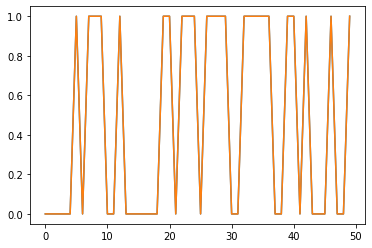

In [137]:
plt.plot(pred)
plt.plot(y_val)

In [279]:
models, evaluation, model_descriptions, predictions, indices = training(data_raw, y)

TypeError: training() missing 1 required positional argument: 'reduce'

In [36]:
indices

[array([ 717,  726,  262, 1027, 1035,  200,  199,  437,  600,    6]),
 array([ 717,  726,  262, 1027, 1035,  200,  199,  437,  600,    6]),
 array([ 717,  726,  262, 1027, 1035,  200,  199,  437,  600,    6]),
 array([ 717,  726,  262, 1027, 1035,  200,  199,  437,  600,    6]),
 array([ 717,  726,  262, 1027, 1035,  200,  199,  437,  600,    6]),
 [88, 408, 625, 643, 673, 959, 1037, 1041, 1043, 1044],
 [88, 408, 625, 643, 673, 959, 1037, 1041, 1043, 1044],
 [88, 408, 625, 643, 673, 959, 1037, 1041, 1043, 1044],
 [88, 408, 625, 643, 673, 959, 1037, 1041, 1043, 1044],
 [88, 408, 625, 643, 673, 959, 1037, 1041, 1043, 1044]]

In [57]:
plt.figure(figsize=(20, 8))
plt.bar(height=evaluation, x=model_descriptions)
plt.title("Model performance")
plt.show()

NameError: name 'evaluation' is not defined

<Figure size 1440x576 with 0 Axes>